# Aiffel Mini Project - Explorestage 10

# Deep Learning(Natural Language Processing) Mini project

## Machine Transrator(seq2seq)

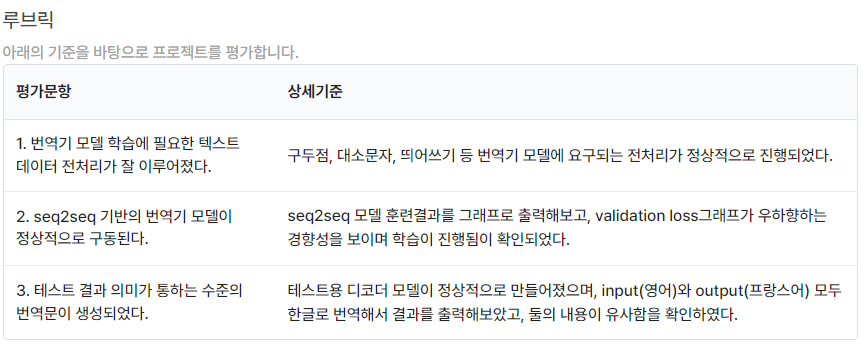

# 10-10. Project : Upgrading the translation system at the word level.(단어 Level로 번역기 업그레이드하기)

프로젝트를 진행하기 전에 주요 라이브러리 버전을 확인해 보죠.

In [1]:
import tensorflow

print(tensorflow.__version__)

2.6.0


실습에서 구현한 번역기는 글자 단위(Character-level)에서 구현된 번역기였습니다. 하지만 실제 번역기의 경우에는 글자 단위가 아니라 단어 단위(Word-level)에서 구현되는 것이 좀 더 보편적입니다.

동일한 데이터셋을 사용하면서 글자 단위와는 다른 전처리와 to_categorical() 함수가 아닌 임베딩 층(Embedding layer)를 추가하여 단어 단위의 번역기를 완성시켜보겠습니다. 하지만, 단어 단위로 할 경우에는 단어의 개수가 글자 단위로 했을 경우와 비교하여 단어장의 크기(Vocabulary) 크기도 커지고, 학습 속도도 좀 더 느려집니다. 학습과 테스트 시의 원활한 진행을 위해서 데이터에서 상위 33,000개의 샘플만 사용해주세요.

33000개 중 3000개는 테스트 데이터로 분리하여 모델을 학습한 후에 번역을 테스트 하는 용도로 사용합니다.

In [2]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import keras
import numpy as np
import time
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'


### Step 1. Cleaning, normalization, preprocessing (both in English and French!).(정제, 정규화, 전처리 (영어, 프랑스어 모두!))
----
글자 단위가 아닌 단어 단위의 번역기를 하기 위해서는 글자 단위에서는 신경쓰지 않았던 몇 가지 추가적인 전처리가 필요합니다.

1. Please separate punctuation marks from words.  
    (구두점(Punctuation)을 단어와 분리해주세요.)

일반적으로 영어권 언어의 경우에는 띄어쓰기 단위로 단어를 분리합니다. 토큰화(Tokenization) 라고도 불리는 이 작업은 어디서부터 어디까지가 하나의 단어인지를 구분하는 작업인데요, 그런데 띄어쓰기를 해주기 전에 구두점을 분리하는 작업이 필요할 때가 있습니다.
예를 들어서 'he is a good boy!'라는 문장이 있을 때, 이를 띄어쓰기 단위로 토큰화한다면 ['he', 'is', 'a', 'good', 'boy!']가 됩니다. 그런데 실제로 !는 boy와 붙어있는 한 단어가 아니므로 좀 더 올바른 전처리는 ['he', 'is', 'a', 'good', 'boy', '!']가 맞습니다.
!나 ? 또는 온점과 같은 특수문자들을 구두점(punctuation)이라고 부릅니다. 이들을 토큰화하기 전에 단어와 미리 분리시켜주세요!

- 분리 전 : he is a Good boy!
- 분리 후 : he is a Good boy !


2. Please convert it to lowercase.(소문자로 바꿔주세요.)

기계가 보기에는 스펠링이 같더라도 대문자로 된 단어와 소문자로 된 단어는 서로 다른 단어입니다. 예를 들어 'Good'과 'good'은 기계가 보기에는 다른 단어입니다. 그래서 모든 문장에 대해서 전부 영어로 바꿔주는 작업을 하겠습니다.

- 변환 전 : he is a Good boy !
- 변환 후 : he is a good boy !

3. Perform tokenization on a whitespace basis.  
    (띄어쓰기 단위로 토큰화를 수행하세요.)

띄어쓰기 단위로 토큰화를 수행해서 단어를 분리하는 작업을 해주세요. 기계는 이렇게 분리된 토큰들을 각각 하나의 단어로 인식할 수 있게 됩니다.

- 토큰화 전 : 'he is a good boy !'
- 토큰화 후 : ['he', 'is', 'a', 'good', 'boy', '!']

#### Cleaning(정제)

In [3]:
file_path = './data/fra.txt'
df_lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(df_lines))
df_lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 197463


,eng,fra,cc
122421,Ferrets are playful and curious.,Les furets sont joueurs et curieux.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
36962,I'm sick of English.,J'en ai marre de l'anglais.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
59287,That war ended in 1954.,Cette guerre se termina en 1954.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
69920,Do you mind if I come in?,Voyez-vous un inconvénient à ce que j'entre ?,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
179771,The armed forces occupied the entire territory.,Les forces armées occupèrent l’entièreté du te...,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


In [4]:
lines = df_lines[['eng', 'fra']][:55000] # 5만개 샘플 사용
lines.sample(5)

,eng,fra
44429,My nerves are frayed.,Mes nerfs sont à vif.
25446,My knife is sharp.,Mon couteau est affûté.
19483,I'm not the boss.,Je ne suis pas le patron.
50465,I went out by bicycle.,Je suis sortie en vélo.
42600,I heard my pants rip.,J'ai entendu mon pantalon se déchirer.


In [5]:
lines.head(10)

,eng,fra
0,Go.,Va !
1,Go.,Marche.
2,Go.,En route !
3,Go.,Bouge !
4,Hi.,Salut !
5,Hi.,Salut.
6,Run!,Cours !
7,Run!,Courez !
8,Run!,Prenez vos jambes à vos cous !
9,Run!,File !


In [6]:
lines.tail()

,eng,fra
54995,Can't they do anything?,Ne peuvent-ils rien faire ?
54996,Can't you see I'm busy?,Ne peux-tu voir que je suis occupé ?
54997,Can't you see I'm busy?,Ne peux-tu voir que je suis occupée ?
54998,Can't you see I'm busy?,Ne pouvez-vous voir que je suis occupé ?
54999,Can't you see I'm busy?,Ne pouvez-vous voir que je suis occupée ?


#### Word tokenization(단어토크나이징)
- nltk 라이브러리를 사용해서 단어토크나이징을 시도한다. 
- 토크나이징을 하며 시작토큰('\<start>')과 종료 토큰('\<end>')도 같이 붙인다. 

In [7]:
from nltk.tokenize import TreebankWordTokenizer

tokenizer = TreebankWordTokenizer()

In [8]:
lines.fra = lines.fra.apply(lambda x : tokenizer.tokenize(x))
lines.eng = lines.eng.apply(lambda x : tokenizer.tokenize(x))

In [9]:
sos_token = ['<start>']
eos_token = ['<end>']
lines.fra = lines.fra.apply(lambda x : sos_token + x + eos_token)
print('전체 샘플의 수 :',len(lines))
lines.sample(5)

전체 샘플의 수 : 55000


,eng,fra
8645,"[They, must, die, .]","[<start>, Elles, doivent, mourir, ., <end>]"
44478,"[No, one, seemed, afraid, .]","[<start>, Personne, ne, semblait, effrayé, ., ..."
47576,"[Says, who, ?, ``, Says, me, ., '']","[<start>, «, Qui, dit, ça, ?, », «, Je, le, di..."
13125,"[Are, you, leaving, ?]","[<start>, Allez-vous, partir, ?, <end>]"
52975,"[Tom, greeted, us, warmly, .]","[<start>, Tom, nous, accueillit, chaleureuseme..."


In [10]:
lines.head(10)

,eng,fra
0,"[Go, .]","[<start>, Va, !, <end>]"
1,"[Go, .]","[<start>, Marche, ., <end>]"
2,"[Go, .]","[<start>, En, route, !, <end>]"
3,"[Go, .]","[<start>, Bouge, !, <end>]"
4,"[Hi, .]","[<start>, Salut, !, <end>]"
5,"[Hi, .]","[<start>, Salut, ., <end>]"
6,"[Run, !]","[<start>, Cours, !, <end>]"
7,"[Run, !]","[<start>, Courez, !, <end>]"
8,"[Run, !]","[<start>, Prenez, vos, jambes, à, vos, cous, !..."
9,"[Run, !]","[<start>, File, !, <end>]"


#### Shuffling the DataFrame(Dataframe 셔플)
- There is a higher possibility of negativity in grades, but we attempt shuffling for greater robust.  
    (성적에는 좀 부정적 일 가능성이 높지만 좀더 높은 범용성을 위해 셔플을 시도한다.)

In [11]:
lines_shuf = lines.iloc[np.random.permutation(lines.index)].reset_index(drop=True)

In [12]:
lines_shuf.head(10)

,eng,fra
0,"[Did, you, not, know, that, ?]","[<start>, Ne, le, saviez-vous, pas, ?, <end>]"
1,"[I, 'm, already, married, .]","[<start>, Je, suis, déjà, mariée, ., <end>]"
2,"[I, 'm, dirty, .]","[<start>, Je, suis, sale, ., <end>]"
3,"[I, 'll, go, with, you, .]","[<start>, J'irai, avec, vous, ., <end>]"
4,"[Look, at, those, clouds, .]","[<start>, Regarde, ces, nuages, ., <end>]"
5,"[We, 're, in, no, hurry, .]","[<start>, Nous, ne, sommes, pas, pressées, ., ..."
6,"[We, 're, done, .]","[<start>, Nous, avons, terminé, ., <end>]"
7,"[I, was, canned, .]","[<start>, On, m'a, saqué, ., <end>]"
8,"[It, 's, dark, .]","[<start>, C'est, sombre, ., <end>]"
9,"[Tom, has, lots, of, toys, .]","[<start>, Tom, a, beaucoup, de, jouets, ., <end>]"


### Step 2. Insertion of start and end tokens in the decoder's sentence.(디코더의 문장에 시작 토큰과 종료 토큰을 넣어주세요.)
----
글자 단위 번역기를 구현할 때와 마찬가지로 디코더의 입력 시퀀스 맨 앞에는 시작을 의미하는 토큰인 <sos>가 필요합니다. 그리고 교사 강요를 수행할 때, 디코더의 실제값이 되는 디코더의 레이블 시퀀스에는 종료를 의미하는 종료 토큰 <eos>가 필요합니다.
예를 들어 번역 문장이 "Courez!" 였다고 한다면, Step 1을 거친 후에는 다음과 같은 결과를 얻습니다.

- Step 1을 수행한 후 : ['courez', '!']

이 문장에 대해서 각각 디코더의 입력 시퀀스와 레이블 시퀀스를 만들면 다음과 같습니다.

- 입력 시퀀스 : ['<sos>', 'courez', '!']
- 레이블 시퀀스 : ['courez', '!', '<eos>']

참고로 Step 2가 반드시 Step 1이 끝난 후에 이루어질 필요는 없습니다!
Step 1을 수행하는 중간에 수행해도 상관없습니다

### Step 3. Integer encoding text using Keras' Tokenizer.(케라스의 토크나이저로 텍스트를 숫자로 바꿔보세요.)
----

딥러닝 모델은 텍스트가 아닌 숫자를 처리합니다. 케라스 토크나이저를 사용해서 각 단어를 고유한 정수로 바꿔보세요.
케라스 토크나이저의 사용법은 아래의 링크에서 2. 케라스(Keras)의 텍스트 전처리에 설명되어 있습니다.

- [위키독스](https://wikidocs.net/31766)

위 링크의 가이드를 통해서 영어와 프랑스어에 대한 토크나이저를 각각 생성하고, tokenizer.texts_to_sequences()를 사용하여 모든 샘플에 대해서 정수 시퀀스로 변환해보세요.

#### English integer encoding.(영어 정수 인코딩)

In [13]:
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(lines_shuf.eng)

In [14]:
input_text = eng_tokenizer.texts_to_sequences(lines_shuf.eng)
input_text[:5]

[[27, 3, 28, 48, 16, 4],
 [2, 17, 267, 326, 1],
 [2, 17, 644, 1],
 [2, 35, 33, 81, 3, 1],
 [76, 62, 315, 3475, 1]]

In [15]:
print('English Vocab Length:', len(eng_tokenizer.word_index))

English Vocab Length: 6426


#### French integer encoding.(프랑스어 정수 인코딩)

In [16]:
fra_tokenizer = Tokenizer()
fra_tokenizer.fit_on_texts(lines_shuf.fra)
target_text = fra_tokenizer.texts_to_sequences(lines_shuf.fra) 
target_text[:5]

[[1, 10, 13, 3047, 7, 5, 2],
 [1, 4, 16, 196, 1253, 3, 2],
 [1, 4, 16, 900, 3, 2],
 [1, 587, 79, 9, 3, 2],
 [1, 214, 232, 5431, 3, 2]]

In [17]:
print('French Vocab Length:', len(fra_tokenizer.word_index))

French Vocab Length: 13620


#### Check the results of integer encoding.(정수인코딩 결과 확인)

In [18]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 6427
프랑스어 단어장의 크기 : 13621


In [19]:
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 10
프랑스어 시퀀스의 최대 길이 18


In [20]:
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 55000
영어 단어장의 크기 : 6427
프랑스어 단어장의 크기 : 13621
영어 시퀀스의 최대 길이 10
프랑스어 시퀀스의 최대 길이 18


### Step 4. Using an embedding layer.(임베딩 층(Embedding layer) 사용하기)
----
이번에는 입력이 되는 각 단어를 임베딩 층을 사용하여 벡터화하겠습니다.
임베딩 층을 사용하는 방법과 그 설명에 대해서는 아래의 링크의 1. 케라스 임베딩 층(Keras Embedding layer) 을 참고하세요.

- [위키독스](https://wikidocs.net/33793)

실제 번역기 구현을 위해서 사용할 수 있는 인코더 코드의 예시는 다음과 같습니다. 이를 통해서 인코더와 디코더의 임베딩 층을 각각 구현해보세요.

```python
from tensorflow.keras.layers import Input, Embedding, Masking

# 인코더에서 사용할 임베딩 층 사용 예시
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(단어장의 크기, 임베딩 벡터의 차원)(encoder_inputs)
encoder_lstm = LSTM(hidden state의 크기, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
```

주의할 점은 인코더와 디코더의 임베딩 층은 서로 다른 임베딩 층을 사용해야 하지만, 디코더의 훈련 과정과 테스트 과정(예측 과정)에서의 임베딩 층은 동일해야 한다는 것입니다!

In [21]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

In [22]:
sos_token = '<start>'
eos_token = '<end>'

In [23]:
encoder_input = input_text
# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in target_text] 
# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[sos_token] ] for line in target_text]

In [24]:
print(decoder_input[:3])
print(decoder_target[:3])

[[1, 10, 13, 3047, 7, 5], [1, 4, 16, 196, 1253, 3], [1, 4, 16, 900, 3]]
[[10, 13, 3047, 7, 5, 2], [4, 16, 196, 1253, 3, 2], [4, 16, 900, 3, 2]]


In [25]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (55000, 10)
프랑스어 입력데이터의 크기(shape) : (55000, 18)
프랑스어 출력데이터의 크기(shape) : (55000, 18)


In [26]:
n_of_val = 3000
n_of_test = 3000

encoder_input_train = encoder_input[:-(n_of_val+n_of_test)]
decoder_input_train = decoder_input[:-(n_of_val+n_of_test)]
decoder_target_train = decoder_target[:-(n_of_val+n_of_test)]

encoder_input_val = encoder_input[-(n_of_val+n_of_test):-n_of_val]
decoder_input_val = decoder_input[-(n_of_val+n_of_test):-n_of_val]
decoder_target_val = decoder_target[-(n_of_val+n_of_test):-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]


print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input_train))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input_train))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target_train))

영어 학습데이터의 크기(shape) : (49000, 10)
프랑스어 학습 입력데이터의 크기(shape) : (49000, 18)
프랑스어 학습 출력데이터의 크기(shape) : (49000, 18)


In [27]:
encoder_input_train[:5]

array([[  27,    3,   28,   48,   16,    4,    0,    0,    0,    0],
       [   2,   17,  267,  326,    1,    0,    0,    0,    0,    0],
       [   2,   17,  644,    1,    0,    0,    0,    0,    0,    0],
       [   2,   35,   33,   81,    3,    1,    0,    0,    0,    0],
       [  76,   62,  315, 3475,    1,    0,    0,    0,    0,    0]])

In [28]:
decoder_input_train[:5]

array([[   1,   10,   13, 3047,    7,    5,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [   1,    4,   16,  196, 1253,    3,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [   1,    4,   16,  900,    3,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [   1,  587,   79,    9,    3,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [   1,  214,  232, 5431,    3,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0]])

In [29]:
decoder_target_train[0:5]

array([[  10,   13, 3047,    7,    5,    2,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [   4,   16,  196, 1253,    3,    2,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [   4,   16,  900,    3,    2,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [ 587,   79,    9,    3,    2,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [ 214,  232, 5431,    3,    2,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0]])

#### Building an embedding model and an encoder model.(임베딩 모델 및 인코더 모델 빌딩)


In [30]:
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(eng_vocab_size, 100)(encoder_inputs)
enc_masking = Masking(mask_value=0.0)(enc_emb) # 패딩 0은 연산에서 제외
encoder_lstm = LSTM(units=256, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking)
encoder_states = [state_h, state_c]

### Step 5. Implementing the model.모델 구현하기
----
글자 단위 번역기에서 구현한 모델을 참고로 단어 단위 번역기의 모델을 완성시켜보세요! 이때는 label이 integer 값이므로 categorical entropy loss가 아닌 sparse categorical entropy loss를 사용합니다.

#### Building the decoder model.디코더 모델 빌드

In [31]:
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(fra_vocab_size, 100) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) # 패딩 0은 연산에서 제외
dec_masking = Masking(mask_value=0.0)(dec_emb)

In [32]:
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder_lstm(dec_masking, initial_state=encoder_states)
decoder_dense = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [33]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [34]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    642700      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    1362100     input_2[0][0]                    
______________________________________________________________________________________________

#### Testing training time and training performance according to batch size.(배치사이즈에 따른 훈련시간 및 훈련적합도 테스트)
- Checking how training time varies according to batch size.  
    (배치사이즈에 따라 훈련시간이 어떻게 달라지는지 체크해본다.)
- Checking if the amount of training varies according to batch size.  
    (또한 배치사이즈에따라 훈련량이 달라지는지 확인해 본다. )
- reference([링크](https://lynnshin.tistory.com/14), [링크](https://stackoverflow.com/questions/43178668/record-the-computation-time-for-each-epoch-in-keras-during-model-fit))

#### 임베딩 정보 저장 문제
- 재미있는 현상을 발견했다. 애초 배치사이즈에 따른 훈련시간과 정확도를 체크해보려고 한 시험이었는데, 훈련을 할때 마다 테스트를 하느라 소수의 에폭을 돌리고 중단한 loss값 즈음에서 훈련이 시작되고 있었다. 
- 아무래도 현재 모델 빌드 방법이 변수에 결과값들을 계속 저장하는 형태여서 그 값들이 남아있는게 아닐까 싶다. 
- 특히 임베딩레이어에 정보가 남아있는게 아닐까 강력히 의심이 된다. 
- 리셋 명령어로 리셋시킬수도 있지만 그보다는 할때마다 전체 모델빌드를 다시하기로 한다. 
- 일단한 20에폭까지는 훈련이 꾸준히 되고 있음을 발견한것도 성과이다. 
- 만약 다른 정보가아니라 임베딩 레이어의 임베딩백터값들이 남아있어서 훈련이 이어지는거라면 nlp모델에서 임베딩 레이어가 갖는 중요도를 체험 할 수 잇었다. 

In [35]:
# 훈련시간 체크 객체
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [36]:
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(eng_vocab_size, 100)(encoder_inputs)
enc_masking = Masking(mask_value=0.0)(enc_emb) # 패딩 0은 연산에서 제외
encoder_lstm = LSTM(units=256, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(fra_vocab_size, 100) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) # 패딩 0은 연산에서 제외
dec_masking = Masking(mask_value=0.0)(dec_emb)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder_lstm(dec_masking, initial_state=encoder_states)
decoder_dense = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [37]:
model_128 = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model_128.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [38]:
time_callback = TimeHistory()

history_128 = model_128.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data = ([encoder_input_val, decoder_input_val], decoder_target_val), callbacks=[time_callback],
          batch_size=128, epochs=10)

Epoch 1/10
383/383 [==============================] - 64s 110ms/step - loss: 2.0693 - acc: 0.7224 - val_loss: 1.5135 - val_acc: 0.7792
Epoch 2/10
383/383 [==============================] - 28s 72ms/step - loss: 1.3877 - acc: 0.7879 - val_loss: 1.2885 - val_acc: 0.8029
Epoch 3/10
383/383 [==============================] - 28s 72ms/step - loss: 1.1862 - acc: 0.8114 - val_loss: 1.1308 - val_acc: 0.8244
Epoch 4/10
383/383 [==============================] - 27s 69ms/step - loss: 1.0366 - acc: 0.8317 - val_loss: 1.0314 - val_acc: 0.8366
Epoch 5/10
383/383 [==============================] - 27s 70ms/step - loss: 0.9316 - acc: 0.8420 - val_loss: 0.9602 - val_acc: 0.8447
Epoch 6/10
383/383 [==============================] - 27s 70ms/step - loss: 0.8452 - acc: 0.8504 - val_loss: 0.9033 - val_acc: 0.8512
Epoch 7/10
383/383 [==============================] - 27s 70ms/step - loss: 0.7710 - acc: 0.8575 - val_loss: 0.8591 - val_acc: 0.8553
Epoch 8/10
383/383 [==============================] - 27s 70m

In [39]:
print(time_callback.times)

[64.27931118011475, 27.641483068466187, 27.550076246261597, 26.509252071380615, 26.817586421966553, 26.82435369491577, 26.93915629386902, 26.900094509124756, 26.553830862045288, 26.802655696868896]


In [40]:
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(eng_vocab_size, 100)(encoder_inputs)
enc_masking = Masking(mask_value=0.0)(enc_emb) # 패딩 0은 연산에서 제외
encoder_lstm = LSTM(units=256, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(fra_vocab_size, 100) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) # 패딩 0은 연산에서 제외
dec_masking = Masking(mask_value=0.0)(dec_emb)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder_lstm(dec_masking, initial_state=encoder_states)
decoder_dense = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [41]:
model_256 = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model_256.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [42]:
time_callback = TimeHistory()

history_256 = model_256.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data = ([encoder_input_val, decoder_input_val], decoder_target_val), callbacks=[time_callback],
          batch_size=256, epochs=10)

Epoch 1/10
192/192 [==============================] - 35s 107ms/step - loss: 2.4741 - acc: 0.6862 - val_loss: 1.6881 - val_acc: 0.7451
Epoch 2/10
192/192 [==============================] - 15s 79ms/step - loss: 1.5509 - acc: 0.7746 - val_loss: 1.4625 - val_acc: 0.7832
Epoch 3/10
192/192 [==============================] - 15s 79ms/step - loss: 1.3746 - acc: 0.7885 - val_loss: 1.3218 - val_acc: 0.7997
Epoch 4/10
192/192 [==============================] - 15s 79ms/step - loss: 1.2503 - acc: 0.8052 - val_loss: 1.2278 - val_acc: 0.8124
Epoch 5/10
192/192 [==============================] - 15s 79ms/step - loss: 1.1551 - acc: 0.8155 - val_loss: 1.1524 - val_acc: 0.8209
Epoch 6/10
192/192 [==============================] - 16s 81ms/step - loss: 1.0698 - acc: 0.8259 - val_loss: 1.0828 - val_acc: 0.8305
Epoch 7/10
192/192 [==============================] - 15s 80ms/step - loss: 0.9950 - acc: 0.8344 - val_loss: 1.0278 - val_acc: 0.8358
Epoch 8/10
192/192 [==============================] - 15s 80m

In [43]:
print(time_callback.times)

[35.35173463821411, 15.180588722229004, 15.180079936981201, 15.102895498275757, 15.188777685165405, 15.528007745742798, 15.290064811706543, 15.277812957763672, 15.364628076553345, 15.33026671409607]


In [44]:
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(eng_vocab_size, 100)(encoder_inputs)
enc_masking = Masking(mask_value=0.0)(enc_emb) # 패딩 0은 연산에서 제외
encoder_lstm = LSTM(units=256, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(fra_vocab_size, 100) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) # 패딩 0은 연산에서 제외
dec_masking = Masking(mask_value=0.0)(dec_emb)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder_lstm(dec_masking, initial_state=encoder_states)
decoder_dense = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [45]:
model_512 = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model_512.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [46]:
time_callback = TimeHistory()

history_512 = model_512.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data = ([encoder_input_val, decoder_input_val], decoder_target_val), callbacks=[time_callback],
          batch_size=512, epochs=10)

Epoch 1/10
96/96 [==============================] - 31s 157ms/step - loss: 3.1037 - acc: 0.6625 - val_loss: 1.8712 - val_acc: 0.6906
Epoch 2/10
96/96 [==============================] - 9s 99ms/step - loss: 1.7954 - acc: 0.7042 - val_loss: 1.7008 - val_acc: 0.7251
Epoch 3/10
96/96 [==============================] - 10s 106ms/step - loss: 1.5986 - acc: 0.7661 - val_loss: 1.5368 - val_acc: 0.7783
Epoch 4/10
96/96 [==============================] - 10s 102ms/step - loss: 1.4820 - acc: 0.7785 - val_loss: 1.4527 - val_acc: 0.7813
Epoch 5/10
96/96 [==============================] - 9s 98ms/step - loss: 1.4016 - acc: 0.7838 - val_loss: 1.3820 - val_acc: 0.7892
Epoch 6/10
96/96 [==============================] - 10s 103ms/step - loss: 1.3269 - acc: 0.7906 - val_loss: 1.3201 - val_acc: 0.7941
Epoch 7/10
96/96 [==============================] - 10s 107ms/step - loss: 1.2640 - acc: 0.7979 - val_loss: 1.2679 - val_acc: 0.8038
Epoch 8/10
96/96 [==============================] - 10s 102ms/step - loss

In [47]:
print(time_callback.times)

[31.221455812454224, 9.47194766998291, 10.131029605865479, 9.761845111846924, 9.4209566116333, 9.851324319839478, 10.252949953079224, 9.788441181182861, 9.72200632095337, 9.912001132965088]


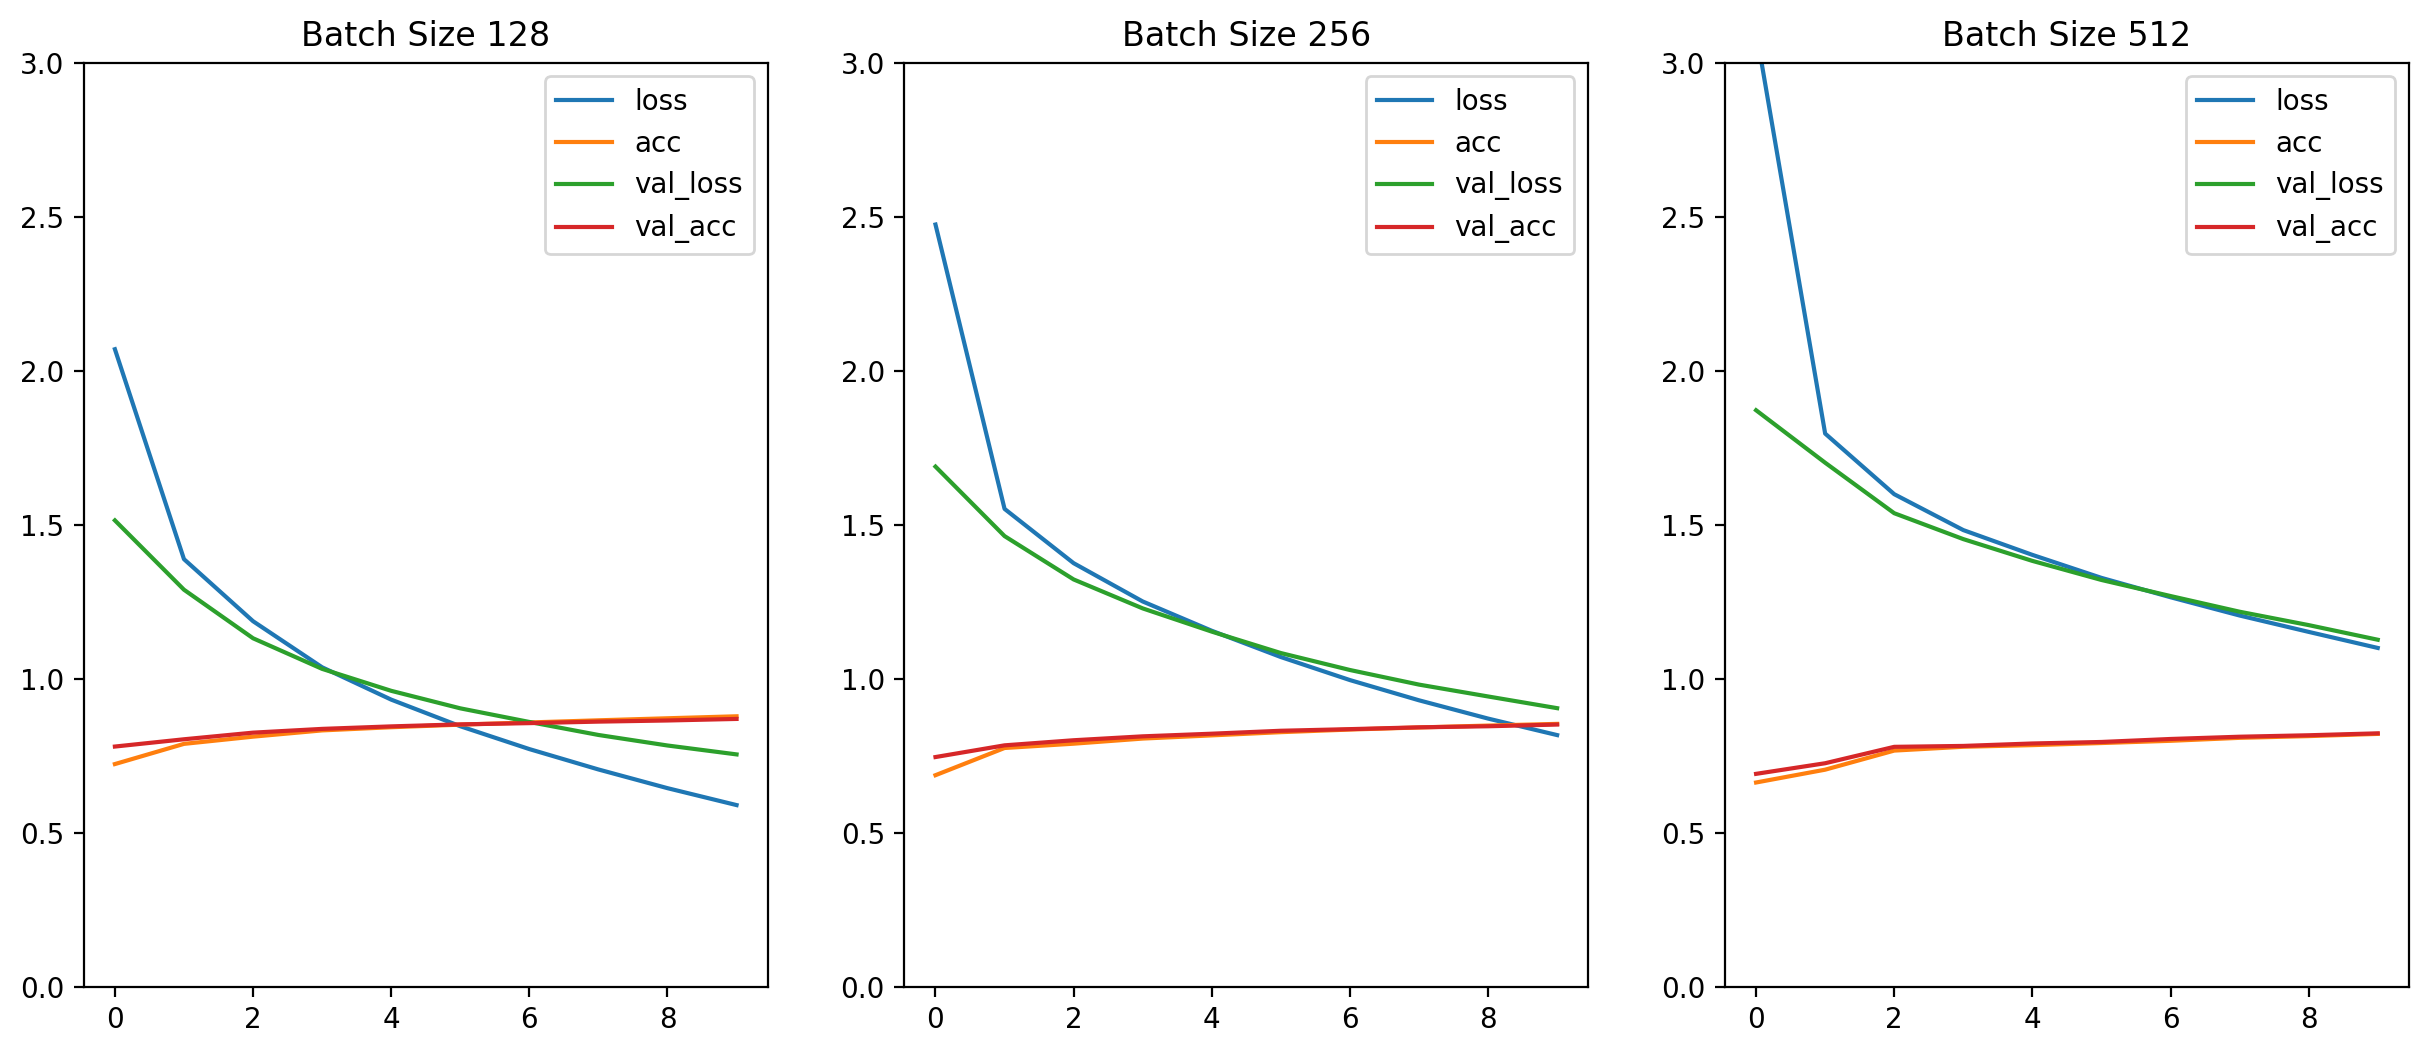

In [48]:
fig = plt.figure(figsize=(15,6))

plt.subplot(1, 3, 1)
for k,v in history_128.history.items():
    plt.plot(history_128.history[k], label=k)
plt.ylim(0, 3)
plt.title('Batch Size 128')
plt.legend()

plt.subplot(1, 3, 2)
for k,v in history_256.history.items():
    plt.plot(history_256.history[k], label=k)
plt.ylim(0, 3)
plt.title('Batch Size 256')
plt.legend()

plt.subplot(1, 3, 3)
for k,v in history_512.history.items():
    plt.plot(history_512.history[k], label=k)
plt.ylim(0, 3)
plt.title('Batch Size 512')
plt.legend()

plt.show()

### Conclusion1(소결론1)
- There was a significant difference in training speed depending on the batch size.  
    (배치사이즈에 따른 훈련속도에는 유의미한 차이가 있었다.)
- As the batch size increased, the rate at which the loss value decreased slowed down.  
    (다만 배치사이즈가 커질수록 loss값이 떨어지는 속도는 저하되었다.)
- It may be worth considering the overall efficiency, but increasing the batch size and extending the total number of epochs could also be a viable approach.  
    (전체 효율을 생각해 볼필요는 있지만 배치사이즈를 크게하고, 전체 에폭을 늘리는것도 방법이 될수 있을 듯 하다.)
- However, the point at which the loss values of the train data and validation data cross was consistently between 2 epochs and 3 epochs.  
    (다만 train data의 loss값과 validation data의 loss값이 크로스하는 지점은 2epoch과 3epoch사이로 일정했다.)
- I plan to train by increasing the batch size.(일단 배치사이즈를 크게 해서 훈련을 해보도록 한다.)

In [49]:
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(eng_vocab_size, 100)(encoder_inputs)
enc_masking = Masking(mask_value=0.0)(enc_emb) # 패딩 0은 연산에서 제외
encoder_lstm = LSTM(units=256, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(fra_vocab_size, 100) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) # 패딩 0은 연산에서 제외
dec_masking = Masking(mask_value=0.0)(dec_emb)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder_lstm(dec_masking, initial_state=encoder_states)
decoder_dense = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [50]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [51]:
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data = ([encoder_input_val, decoder_input_val], decoder_target_val), 
          batch_size=512, epochs=100)

Epoch 1/100
96/96 [==============================] - 31s 156ms/step - loss: 3.1107 - acc: 0.6676 - val_loss: 1.8380 - val_acc: 0.6986
Epoch 2/100
96/96 [==============================] - 10s 100ms/step - loss: 1.7606 - acc: 0.7121 - val_loss: 1.6570 - val_acc: 0.7557
Epoch 3/100
96/96 [==============================] - 10s 102ms/step - loss: 1.5690 - acc: 0.7722 - val_loss: 1.5169 - val_acc: 0.7796
Epoch 4/100
96/96 [==============================] - 9s 98ms/step - loss: 1.4609 - acc: 0.7799 - val_loss: 1.4291 - val_acc: 0.7840
Epoch 5/100
96/96 [==============================] - 9s 98ms/step - loss: 1.3715 - acc: 0.7871 - val_loss: 1.3516 - val_acc: 0.7918
Epoch 6/100
96/96 [==============================] - 9s 99ms/step - loss: 1.2926 - acc: 0.7957 - val_loss: 1.2862 - val_acc: 0.8032
Epoch 7/100
96/96 [==============================] - 9s 99ms/step - loss: 1.2245 - acc: 0.8067 - val_loss: 1.2306 - val_acc: 0.8098
Epoch 8/100
96/96 [==============================] - 9s 99ms/step - lo

96/96 [==============================] - 9s 98ms/step - loss: 0.1237 - acc: 0.9625 - val_loss: 0.6293 - val_acc: 0.8952
Epoch 63/100
96/96 [==============================] - 10s 99ms/step - loss: 0.1200 - acc: 0.9632 - val_loss: 0.6319 - val_acc: 0.8949
Epoch 64/100
96/96 [==============================] - 9s 98ms/step - loss: 0.1167 - acc: 0.9638 - val_loss: 0.6316 - val_acc: 0.8960
Epoch 65/100
96/96 [==============================] - 10s 99ms/step - loss: 0.1137 - acc: 0.9645 - val_loss: 0.6337 - val_acc: 0.8959
Epoch 66/100
96/96 [==============================] - 9s 98ms/step - loss: 0.1104 - acc: 0.9649 - val_loss: 0.6354 - val_acc: 0.8958
Epoch 67/100
96/96 [==============================] - 10s 100ms/step - loss: 0.1079 - acc: 0.9654 - val_loss: 0.6382 - val_acc: 0.8958
Epoch 68/100
96/96 [==============================] - 9s 99ms/step - loss: 0.1050 - acc: 0.9660 - val_loss: 0.6373 - val_acc: 0.8959
Epoch 69/100
96/96 [==============================] - 9s 99ms/step - loss: 0.1

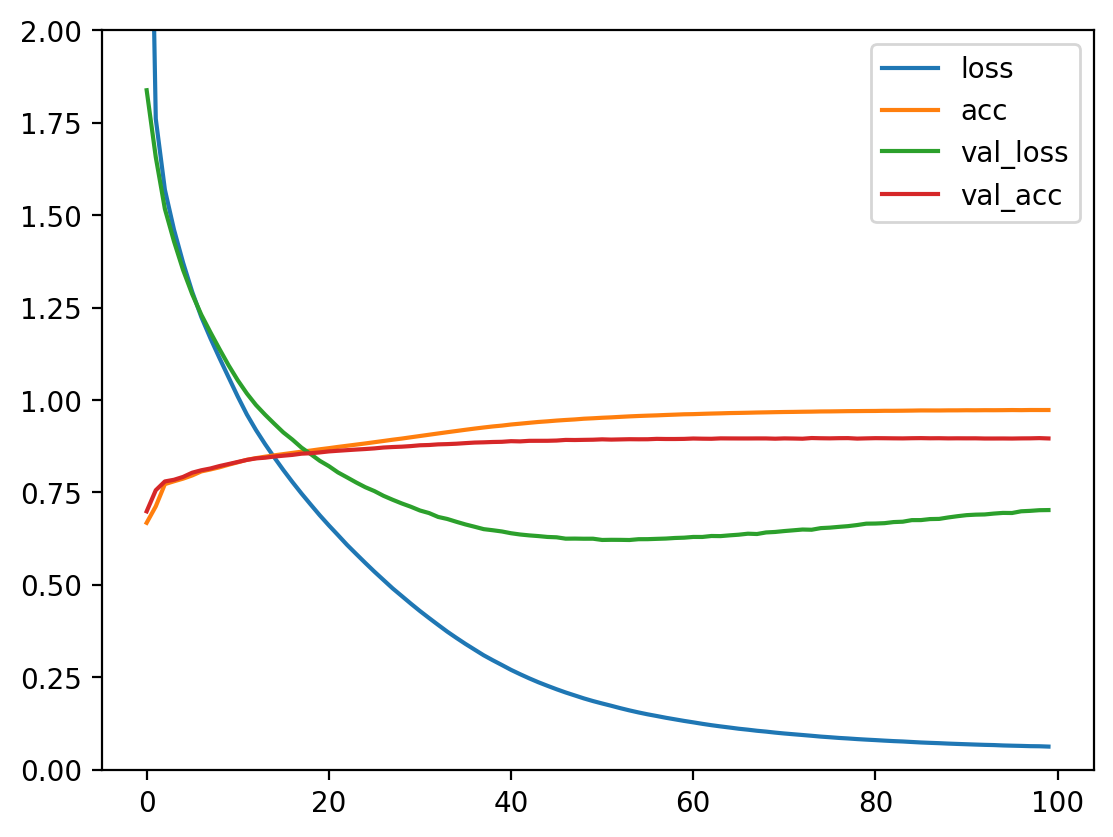

In [52]:
for k,v in history.history.items():
    plt.plot(history.history[k], label=k)
plt.ylim(0, 2)
plt.legend()

plt.show()

### Conclusion2(소결론2)
- The model reached the learning limit based on the validation data accuracy after 60 epochs.  
    (60에폭즈음에서 validation data accuracy 기준으로 학습한계에 도달했다.)
- The learning limit in terms of accuracy is around 0.895.  
    (accuracy상 학습한계는 0.895 즈음이다.)
- I initially set the embedding vector size to 300, but the parameter count increased significantly, so I reduced it to 100 for training. However, it seems necessary to consider increasing the embedding vector size.  
    (임베딩 백터를 300으로 했다가 파라미터가 폭증해서 100으로 낮춰 학습을 했는데, 임베딩 백터를 키워볼 필요도 있어 보인다.)
- 한번더 돌려본다. 

In [56]:
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(eng_vocab_size, 200)(encoder_inputs)
enc_masking = Masking(mask_value=0.0)(enc_emb) # 패딩 0은 연산에서 제외
encoder_lstm = LSTM(units=256, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(fra_vocab_size, 200) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) # 패딩 0은 연산에서 제외
dec_masking = Masking(mask_value=0.0)(dec_emb)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder_lstm(dec_masking, initial_state=encoder_states)
decoder_dense = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [57]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [58]:
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data = ([encoder_input_val, decoder_input_val], decoder_target_val), 
          batch_size=512, epochs=70)

Epoch 1/70
96/96 [==============================] - 32s 177ms/step - loss: 3.0637 - acc: 0.6631 - val_loss: 1.8646 - val_acc: 0.6964
Epoch 2/70
96/96 [==============================] - 11s 113ms/step - loss: 1.7545 - acc: 0.7231 - val_loss: 1.6293 - val_acc: 0.7724
Epoch 3/70
96/96 [==============================] - 11s 113ms/step - loss: 1.5500 - acc: 0.7754 - val_loss: 1.4964 - val_acc: 0.7799
Epoch 4/70
96/96 [==============================] - 11s 112ms/step - loss: 1.4422 - acc: 0.7807 - val_loss: 1.4118 - val_acc: 0.7868
Epoch 5/70
96/96 [==============================] - 11s 113ms/step - loss: 1.3536 - acc: 0.7900 - val_loss: 1.3368 - val_acc: 0.7958
Epoch 6/70
96/96 [==============================] - 11s 113ms/step - loss: 1.2803 - acc: 0.7986 - val_loss: 1.2783 - val_acc: 0.8032
Epoch 7/70
96/96 [==============================] - 11s 112ms/step - loss: 1.2170 - acc: 0.8060 - val_loss: 1.2242 - val_acc: 0.8090
Epoch 8/70
96/96 [==============================] - 10s 109ms/step - 

96/96 [==============================] - 11s 115ms/step - loss: 0.1016 - acc: 0.9668 - val_loss: 0.6186 - val_acc: 0.8972
Epoch 63/70
96/96 [==============================] - 11s 110ms/step - loss: 0.0988 - acc: 0.9671 - val_loss: 0.6218 - val_acc: 0.8969
Epoch 64/70
96/96 [==============================] - 11s 111ms/step - loss: 0.0963 - acc: 0.9676 - val_loss: 0.6237 - val_acc: 0.8973
Epoch 65/70
96/96 [==============================] - 11s 114ms/step - loss: 0.0938 - acc: 0.9679 - val_loss: 0.6266 - val_acc: 0.8971
Epoch 66/70
96/96 [==============================] - 11s 113ms/step - loss: 0.0915 - acc: 0.9685 - val_loss: 0.6295 - val_acc: 0.8966
Epoch 67/70
96/96 [==============================] - 11s 111ms/step - loss: 0.0894 - acc: 0.9687 - val_loss: 0.6286 - val_acc: 0.8967
Epoch 68/70
96/96 [==============================] - 11s 110ms/step - loss: 0.0871 - acc: 0.9693 - val_loss: 0.6335 - val_acc: 0.8969
Epoch 69/70
96/96 [==============================] - 11s 112ms/step - loss

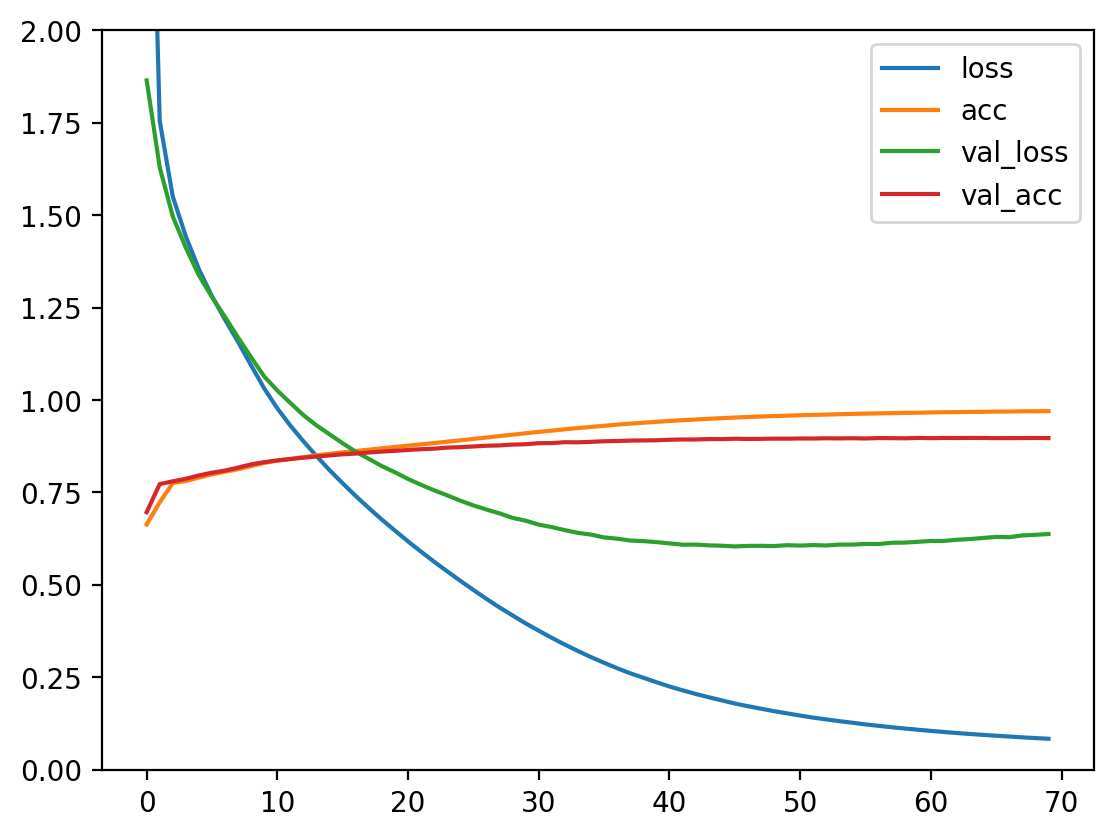

In [59]:
for k,v in history.history.items():
    plt.plot(history.history[k], label=k)
plt.ylim(0, 2)
plt.legend()

plt.show()

#### 소결론3
- 여전히 오버피팅 현상이 나타나고 있는 것으로 보인다. 
- validation data accuracy도 정체를 보이고 있다. 
- data를 늘리면 더 좋아질것 같지만 일단 훈련은 여기서 마무리 한다. 

### Step 6. Evaluating the model(모델 평가하기)
----
단어 단위 번역기를 이용하여 훈련 데이터의 샘플과 테스트 데이터의 샘플로 번역 문장을 만들어보고 정답 문장과 번역 문장을 비교해보세요. 이전 스텝들에서 우리가 공부했던 모델의 경우 글자 단위에서 구현된 번역기이며 현재 프로젝트를 진행할 때 사용하는 모델은 단어 단위에서 구현되는 번역기입니다.

> Embedding layer가 추가되기 때문에 학습했던 내용 그대로 사용할 경우 shape에서 error가 발생합니다.  
> decode sentence를 구성할 때 고민해보세요!!

고민하다 풀리지 않을 경우에는 하단 내용 참고해주세요.

```python
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # 에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1,1)) 
    target_seq[0, 0] = fra2idx['\t']
    
    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # 에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장     
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence
```

#### Redesigning the decoder(디코더 재설계)

In [61]:
encoder_model = Model(encoder_inputs, encoder_states)

# 디코더 설계 시작
# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2 = dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# 모든 시점에 대해서 단어 예측
decoder_outputs2 = decoder_dense(decoder_outputs2)

# 수정된 디코더
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [62]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

#### Implementing a translator(번역기 작성)

In [74]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 마지막 시점의 상태(은닉 상태, 셀 상태)를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 정수 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = fra2idx['<start>']

    stop_condition = False
    decoded_sentence = ''

    # stop_condition이 True가 될 때까지 루프 반복
    # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 단어로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 단어를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
        if (sampled_char == '<end>' or
            len(decoded_sentence) > 30):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [76]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_src(input_seq):
    sentence = ''
    for encoded_word in input_seq:
        if(encoded_word != 0):
            sentence = sentence + idx2eng[encoded_word] + ' '
    return sentence

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_tar(input_seq):
    sentence = ''
    for encoded_word in input_seq:
        if(encoded_word != 0 and encoded_word != fra2idx['<start>'] and encoded_word != fra2idx['<end>']):
            sentence = sentence + idx2fra[encoded_word] + ' '
    return sentence

In [77]:
for seq_index in [3, 50, 100, 300, 1001, 1567, 2333]:
  input_seq = encoder_input_test[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("입력문장 :",seq_to_src(encoder_input_test[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_test[seq_index]))
  print("번역문장 :",decoded_sentence[1:-5])
  print("-"*50)

입력문장 : were you two close ? 
정답문장 : étiez-vous tous deux proches ? 
번역문장 : étiez-vous en deux ? 
--------------------------------------------------
입력문장 : who 's dieting ? 
정답문장 : qui est au régime ? 
번역문장 : qui sont au bureau ? 
--------------------------------------------------
입력문장 : peel these potatoes . 
정답문장 : épluche ces patates . 
번역문장 : ces pommes sont les pommes de 
--------------------------------------------------
입력문장 : stop aggravating me . 
정답문장 : arrête de m'agacer . 
번역문장 : arrête de me plaît . 
--------------------------------------------------
입력문장 : give us a second . 
정답문장 : donnez-nous une seconde . 
번역문장 : donne-nous une seconde . 
--------------------------------------------------
입력문장 : i 'm not mistaken . 
정답문장 : je ne fais pas erreur . 
번역문장 : je ne suis pas là . 
--------------------------------------------------
입력문장 : you look fabulous . 
정답문장 : tu as l'air resplendissante . 
번역문장 : vous avez l'air resplendis
-----------------------------------------------

#### 평가
- 정답문장과 번역문장으로 모두 구글번역기에서 영어로 번역해본다. 

In [82]:
print('입력문장: were you two close?', '정답문장 번역: were you two close?', '번역문장 번역: were you in two?')
print('입력문장: who\'s dieting? ', '정답문장 번역: who is on a diet?', '번역문장 번역: who are in the office?')
print('입력문장: peel these potatoes.', '정답문장 번역: peel those potatoes.', '번역문장 번역: these apples are apples')
print('입력문장: stop aggravating me .', '정답문장 번역: stop annoying me.', '번역문장 번역: stop pleasing me.')
print('입력문장: give us a second.', '정답문장 번역: give us a second.', '번역문장 번역: give us a second.')
print('입력문장: i\'m not mistaken .', '정답문장 번역: I am not mistaken.', '번역문장 번역: I am not here.')
print('입력문장:  you look fabulous.', '정답문장 번역: you look radiant.', '번역문장 번역: you look radiant')


입력문장: were you two close? 정답문장 번역: were you two close? 번역문장 번역: were you in two?
입력문장: who's dieting?  정답문장 번역: who is on a diet? 번역문장 번역: who are in the office?
입력문장: peel these potatoes. 정답문장 번역: peel those potatoes. 번역문장 번역: these apples are apples
입력문장: stop aggravating me . 정답문장 번역: stop annoying me. 번역문장 번역: stop pleasing me.
입력문장: give us a second. 정답문장 번역: give us a second. 번역문장 번역: give us a second.
입력문장: i'm not mistaken . 정답문장 번역: I am not mistaken. 번역문장 번역: I am not here.
입력문장:  you look fabulous. 정답문장 번역: you look radiant. 번역문장 번역: you look radiant


# Reflection(회고)

### Points I paid attention to(신경쓴 점)
- 자연어처리 라이브러리 nltk의 treebanktokenizer로 tokenizing을 시도했다. 
- To enhance versatility, I shuffled the basic sentence data before training since it was organized in a specific order of verbs.  
    (기본 문장데이터가 특정 동사순으로 만들어져 있어서, 좀더 범용성을 위해 훈련전에 기본데이터를 셔플해서 훈련했다.)
- I measured the training speed and training volume according to the batch size.  
    (배치사이즈에 따른 훈련속도와 훈련량을 측정해보았다.)
- I attempted model training with different embedding dimensions.  
    (임베딩 차원수를 달리하면 모델 훈련을 시도했다.)

### Weak points(아쉬운점)
- The translation is not completely smooth and several errors have been found.  
    (번역이 완전히 매끄럽지는 못하며, 오류도 여럿 발견되었다.)
- The validation data accuracy during training did not exceed 90%.  
    (훈련시 발리데이션 데이터의 accuracy를 90%이상으로 올리지 못했다.)
- 모델을 lstm레이어를 좀더 쌓아보고 싶었는데 그렇게 하지 못했다. 

### Points for improvement(개선하고 싶은 점)
- I would like to train with more data.(좀더 많은 데이터로 훈련해보고 싶다.)
- I would like to try training with a larger embedding dimension.  
    (임베딩 차원을 좀더 늘려서 훈련해보고 싶다.)

<br/>
<br/>

# 레퍼런스
- https://wikidocs.net/86900
- LMS
- https://lynnshin.tistory.com/14
- https://stackoverflow.com/questions/43178668/record-the-computation-time-for-each-epoch-in-keras-during-model-fit
- https://simpling.tistory.com/19
- https://jiwonkoh.tistory.com/188